In [1]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [2]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import PreprocessSMILES, SimpleRegressions, SmallNN, LstmRegressor, DataLoader, Training

from utils import load_config, seed_everything

import gensim

print(gensim.__version__) # 3.7.1

2024-04-21 21:48:54.427782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 21:48:55.327024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-21 21:48:55.327198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-21 21:48:55.327216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

3.7.1


## Майнинг данных из SMILES и объединение молекул в смеси

In [4]:
############################################################################################################################################
################################################# TRAIN ####################################################################################
directory = './materials/'
preprocessor = PreprocessSMILES(directory, 'canonical_smiles')
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv", "descriptors.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf, "train")
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df.reset_index(drop=True, inplace=True)
mdf['graphs'] = preprocessor.generate_graphs(mdf)
mdf.drop(columns=['oil_property_param_value', 'mol'], inplace=True)
joined_df.head(3)
# X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.out_proj.weight', 'regression.dense.weight', 'regression.dense.bias', 'norm_std', 'norm_mean', 'regression.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,canonical_smiles,smiles,descriptors_array,oil_property_param_value,similarity_vectors,embeddings
0,007b4d7a-b1f8-11ed-93b4-005056921581,"[2246728737, 3537119515, 2245273601, 242354360...","[-3.4431674, -0.62736166, -2.157891, -0.715889...","CCCCCC(C)C, CCCC(C)CCC, CCCCC","CC(C)CCCCC, CCCC(C)CCC, CCCCC","[0.0, 0.0, 0.0, 78.0, 24.0, 15.50558120336457,...",13360.0,"[0.3888888888888889, 0.4, 0.2857142857142857]","[-0.06969255954027176, 0.0007362401811406016, ..."
1,0109d480-f91d-11ec-96ac-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-5.5208826, 0.3777768, -3.6566508, -1.7744193...","CCCCC(C)CC, CCCC(C)CCC, CCCCC, CCCCC(C)C, CCCC...","CCC(C)CCCC, CCCC(C)CCC, CCCCC, CCCCC(C)C, O=C(...","[0.0, 0.0, 0.0, 130.0, 40.0, 25.84263533894095...",111400.0,"[0.4444444444444444, 0.375, 0.5555555555555556...","[0.007303034421056509, 0.09422382712364197, -0..."
2,01bc9ed0-0f2f-11ed-9900-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-2.5844321, 0.054932743, -2.082138, -0.734171...","CCC(CC)C(=O)OC, CCCC(C)CCC, CCCCC","CCC(C(OC)=O)CC, CCCC(C)CCC, CCCCC","[0.0, 0.0, 0.0, 78.0, 24.0, 15.50558120336457,...",16325.0,"[0.16666666666666666, 0.14285714285714285, 0.2...","[-0.05418901517987251, 0.014194982126355171, 0..."


In [5]:
##################################################################################################################
############################################### TEST ################################################################
preprocessor_test = PreprocessSMILES(directory=directory, base_on='canonical_smiles', task = 'test')
mdf_test = preprocessor_test.preprocess_data("test_data_fix_concat.csv", "descriptors_test.csv")
grouped_mdf_test = preprocessor_test.preprocess_mol2vec(mdf_test)
smiles_df_test = preprocessor_test.smiles2sentence(mdf_test)
joined_df_test = pd.merge(grouped_mdf_test, smiles_df_test, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df_test = preprocessor_test.embed_smiles(joined_df_test, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df_test.reset_index(drop=True, inplace=True)
mdf_test['graphs'] = preprocessor_test.generate_graphs(mdf_test)
mdf_test.drop(columns=['mol'], inplace=True)
joined_df_test.head(3)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.out_proj.weight', 'regression.dense.weight', 'regression.dense.bias', 'norm_std', 'norm_mean', 'regression.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,canonical_smiles,smiles,descriptors_array,similarity_vectors,embeddings
0,0189e1f2-2ab8-11ee-8be1-005056921581,"[2246728737, 3542456614, 2245384272, 117312591...","[-2.5093365, -0.48656785, -1.1924767, -0.49072...","CCCC(C)CCC, CCCCCCC","CCCC(C)CCC, CCCCCCC","[0.0, 0.0, 0.0, 52.0, 16.0, 10.118274536094024...",[0.26666666666666666],"[0.0031275684013962746, -0.09104879200458527, ..."
1,02114c6e-eb16-11ed-9974-005056921581,"[2246728737, 3537119515, 2245273601, 84546060,...","[-6.4228168, -1.2596623, -4.4797096, -2.153883...","CCCCOC(=O)C(C)C(=O)OCCCC, CCCCCCCC(C)C(CCCCCC)...","CC(C(OCCCC)=O)C(OCCCC)=O, CCCCCCC(C(C)CCCCCCC)...","[0.0, 0.0, 0.0, 52.0, 16.0, 10.118274536094024...",[0.22857142857142856],"[0.012716226279735565, -0.08009424060583115, -..."
2,03ac1c22-6af9-11ed-8d22-005056921581,"[2246728737, 3537123720, 2245277810, 170459982...","[-11.42185, -0.05583578, -8.702778, 0.75527394...","COC(=O)C(C)(C)C, CCCCCC(C)C, CCCC(CC(C)(CC)C(=...","CC(C)(C)C(OC)=O, CC(C)CCCCC, CCC(C(OC)=O)(CC(C...","[0.0, 0.0, 0.0, 130.0, 40.0, 25.29568634023505...","[0.037037037037037035, 0.2894736842105263, 0.0...","[-0.22275105118751526, -0.059774573892354965, ..."


In [6]:
# TODO: пример графа, на данный момент не используется

mdf['graphs'][0]

Graph(num_nodes=8, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

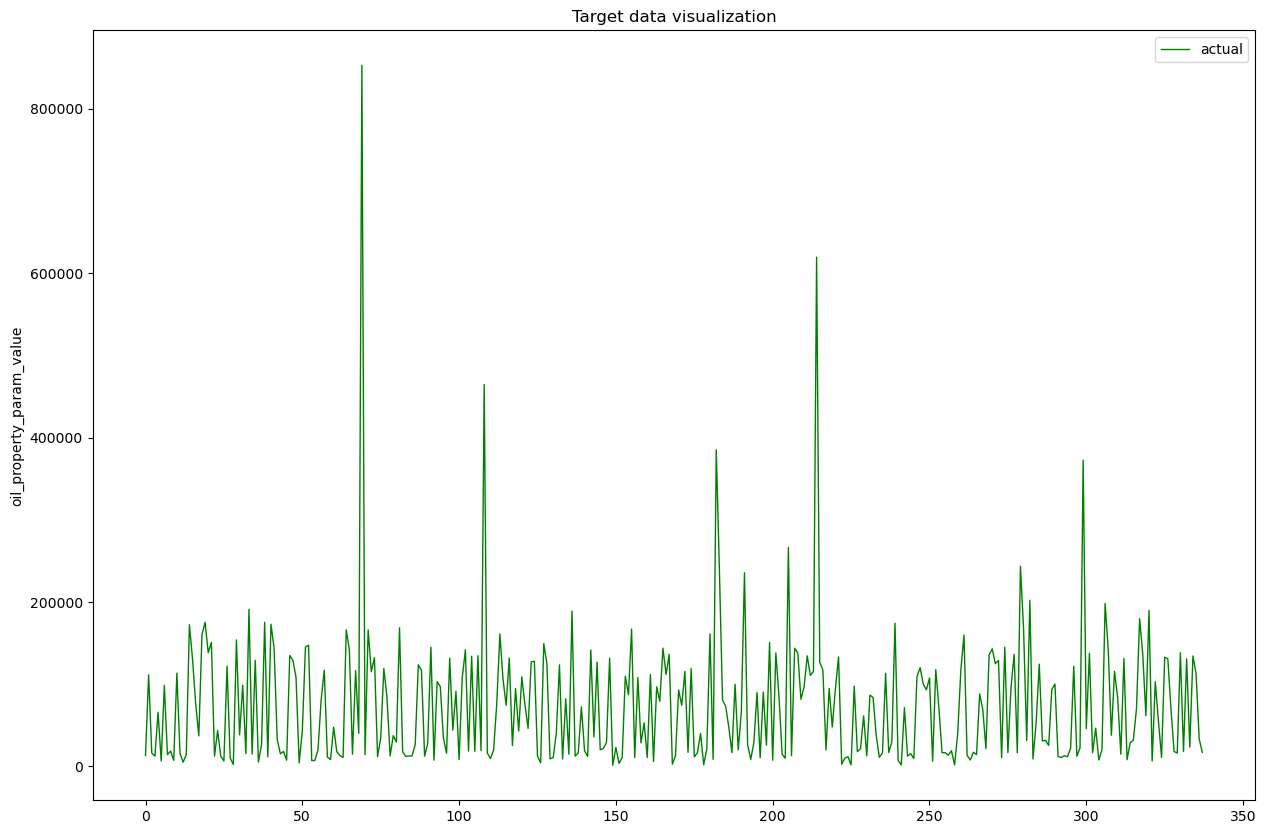

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(joined_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Target data visualization")
plt.show()


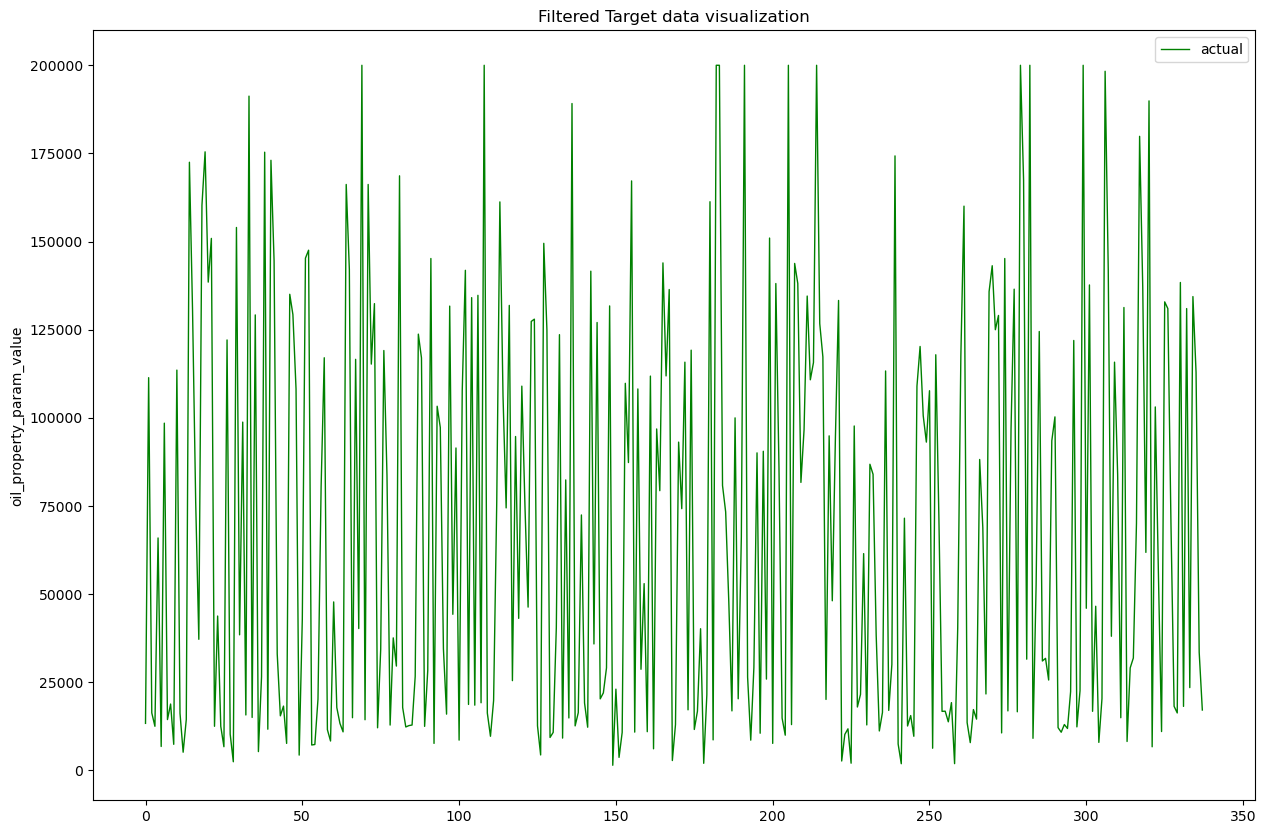

In [8]:
## Обработка выбросов для обучения

joined_df['oil_property_param_value'] = joined_df['oil_property_param_value'].apply(lambda x: min(x, 200000))
plt.figure(figsize=(15, 10))
plt.plot(joined_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Filtered Target data visualization")
plt.show()

## Подготовка данных для обучения на объединенных последовательностях векторов, эмбедингов смеси и близости расстояний между молекулами.


In [9]:
# как similarity_score используется TanimotoSimilarity из rdkit

static_cols = ['embeddings'] #['mol2vec', 'embeddings', 'descriptors_array']
dynamic_cols = [] #['similarity_vectors']

########################################## TRAIN DATALOADER ######################################################

data_loader = DataLoader(joined_df, static_cols, dynamic_cols)
dataset = data_loader.get_dataset()

########################################## TEST DATALOADER  ######################################################

test_data_loader = DataLoader(joined_df_test, static_cols, dynamic_cols, task = 'test')
test_dataset, _ = test_data_loader.get_dataset()

Shape of data_x: (338, 1, 384)
Shape of data_y: (338, 1)
Shape of data_x: (138, 1, 384)


## Тренировка

In [22]:
# Тренировка 3 архитектур нейросеток

config = load_config("config.yml", "embeddings", "torchRegressor")
seed_everything()
trainer = Training(config, dataset.data_x, y=dataset.data_y, test_X = test_dataset.data_x, cross_validation = False)

pred1 = trainer.average_prediction()
pred2 = trainer.weighted_average_prediction(model_wise=[0.29, 0.33, 0.38], fold_wise=[0.30, 0.35, 0.35])

-----Seed Set!-----
lr 0.005


BEST ----> 
GRURegressor Epoch 0, train_loss 1.01, val_loss 1.053, val_mae 55990.44921875
GRURegressor Epoch 1, train_loss 0.911, val_loss 1.2, val_mae 56097.16796875
BEST ----> 
GRURegressor Epoch 2, train_loss 0.842, val_loss 0.877, val_mae 47281.1484375
BEST ----> 
GRURegressor Epoch 3, train_loss 0.785, val_loss 0.792, val_mae 43701.14453125
BEST ----> 
GRURegressor Epoch 4, train_loss 0.803, val_loss 0.74, val_mae 41036.43359375
BEST ----> 
GRURegressor Epoch 5, train_loss 0.73, val_loss 0.695, val_mae 38180.41015625
GRURegressor Epoch 6, train_loss 0.707, val_loss 0.806, val_mae 40084.2734375
GRURegressor Epoch 7, train_loss 0.716, val_loss 0.948, val_mae 49309.96875
GRURegressor Epoch 8, train_loss 0.744, val_loss 0.792, val_mae 40108.78515625
GRURegressor Epoch 9, train_loss 0.722, val_loss 0.854, val_mae 42699.83984375
GRURegressor Epoch 10, train_loss 0.705, val_loss 0.731, val_mae 39878.58984375
GRURegressor Epoch 11, train_loss 0.654, val_loss 0.846, val_mae 42772.27734375


KeyboardInterrupt: 

In [ ]:
trainer.trained_models

[GRURegressor(
   (gru): GRU(32, 2, num_layers=2, batch_first=True)
   (linear): Sequential(
     (0): Linear(in_features=26, out_features=1024, bias=True)
     (1): Dropout(p=0.3, inplace=False)
     (2): ReLU()
     (3): Linear(in_features=1024, out_features=512, bias=True)
     (4): Dropout(p=0.3, inplace=False)
     (5): ReLU()
   )
   (head1): Linear(in_features=512, out_features=1, bias=True)
   (loss1): MSELoss()
   (loss3): L1Loss()
 ),
 ConvRegressor(
   (conv_block): Sequential(
     (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,))
     (1): Dropout(p=0.3, inplace=False)
     (2): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
     (3): ReLU()
     (4): Conv1d(8, 16, kernel_size=(5,), stride=(2,))
     (5): Dropout(p=0.3, inplace=False)
     (6): AvgPool1d(kernel_size=(11,), stride=(11,), padding=(0,))
     (7): Conv1d(16, 4, kernel_size=(3,), stride=(3,))
     (8): Flatten(start_dim=1, end_dim=-1)
   )
   (linear): Sequential(
     (0): Linear(in_features=20, out_features=1024,

## Тренировка Бустингов

Catboost
0:	learn: 0.9624580	test: 1.0758395	best: 1.0758395 (0)	total: 94.2ms	remaining: 3m 8s
1:	learn: 0.9251744	test: 1.0454481	best: 1.0454481 (1)	total: 107ms	remaining: 1m 46s
2:	learn: 0.8948026	test: 1.0155002	best: 1.0155002 (2)	total: 119ms	remaining: 1m 19s
3:	learn: 0.8650870	test: 0.9818051	best: 0.9818051 (3)	total: 133ms	remaining: 1m 6s
4:	learn: 0.8377495	test: 0.9612028	best: 0.9612028 (4)	total: 148ms	remaining: 59s
5:	learn: 0.8123947	test: 0.9353632	best: 0.9353632 (5)	total: 162ms	remaining: 53.8s
6:	learn: 0.7852075	test: 0.9103699	best: 0.9103699 (6)	total: 212ms	remaining: 1m
7:	learn: 0.7565128	test: 0.8918258	best: 0.8918258 (7)	total: 229ms	remaining: 57.1s
8:	learn: 0.7325230	test: 0.8688903	best: 0.8688903 (8)	total: 243ms	remaining: 53.8s
9:	learn: 0.7127751	test: 0.8544945	best: 0.8544945 (9)	total: 255ms	remaining: 50.8s
10:	learn: 0.7001450	test: 0.8409231	best: 0.8409231 (10)	total: 290ms	remaining: 52.4s
11:	learn: 0.6811461	test: 0.8221431	best: 0.

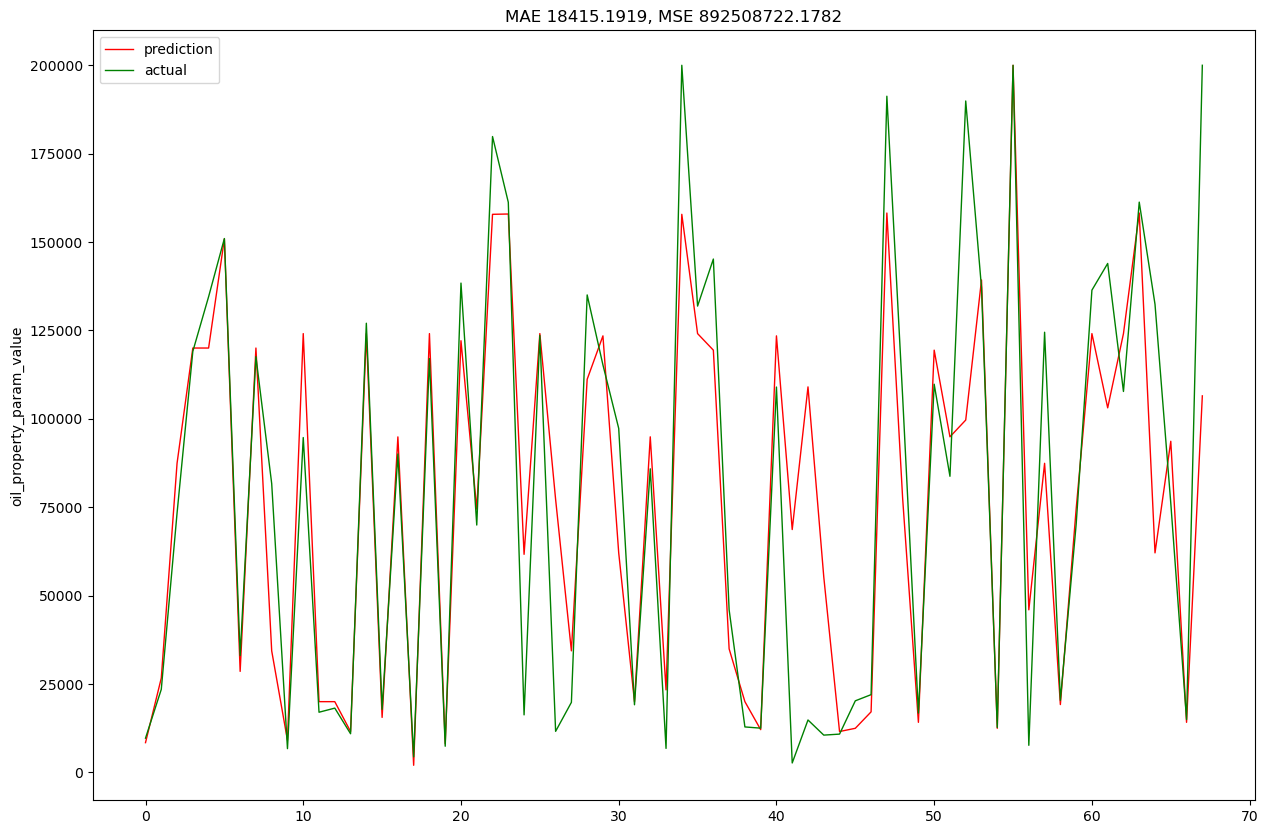

MAE score: 18415.1919
MSE score: 892508722.1782

LGBMRegressor
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23031
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 384
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

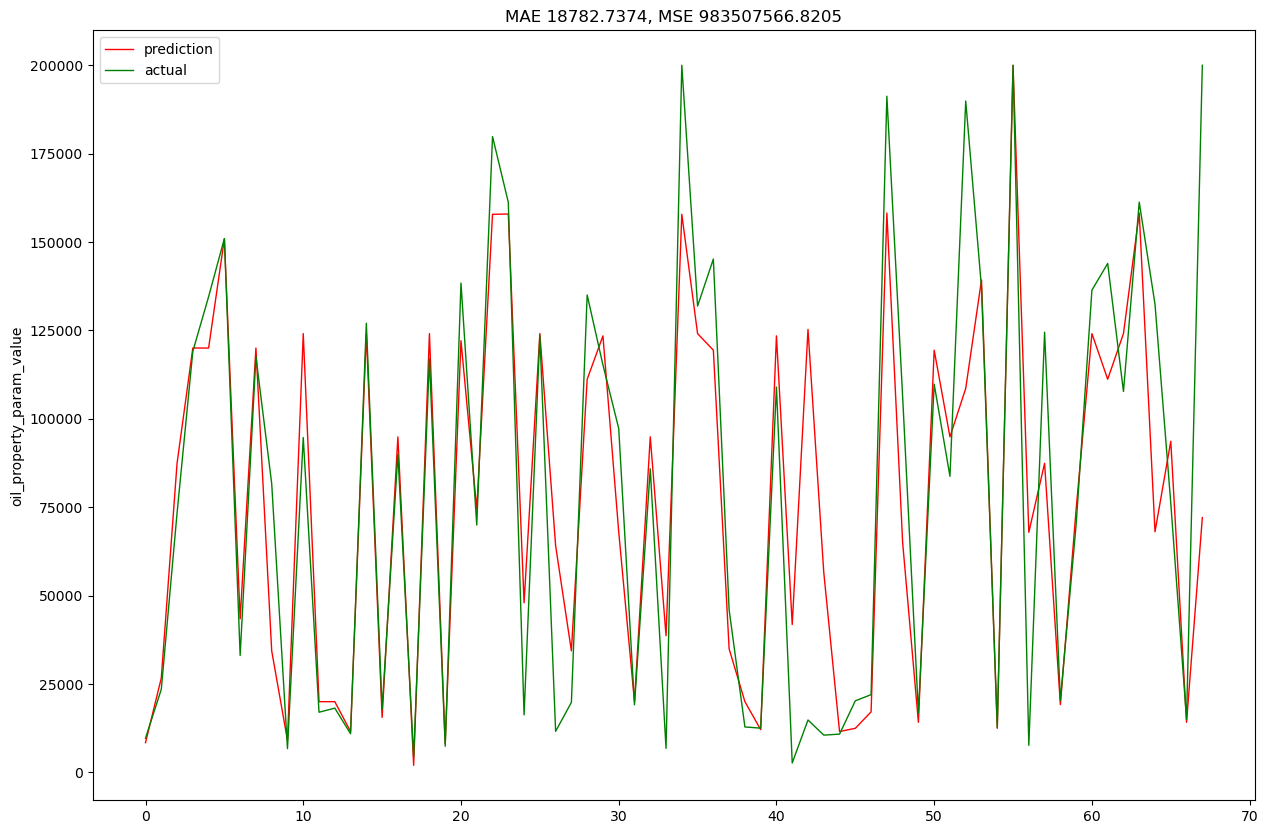

MAE score: 18782.7374
MSE score: 983507566.8205

GradientBoostingRegressor


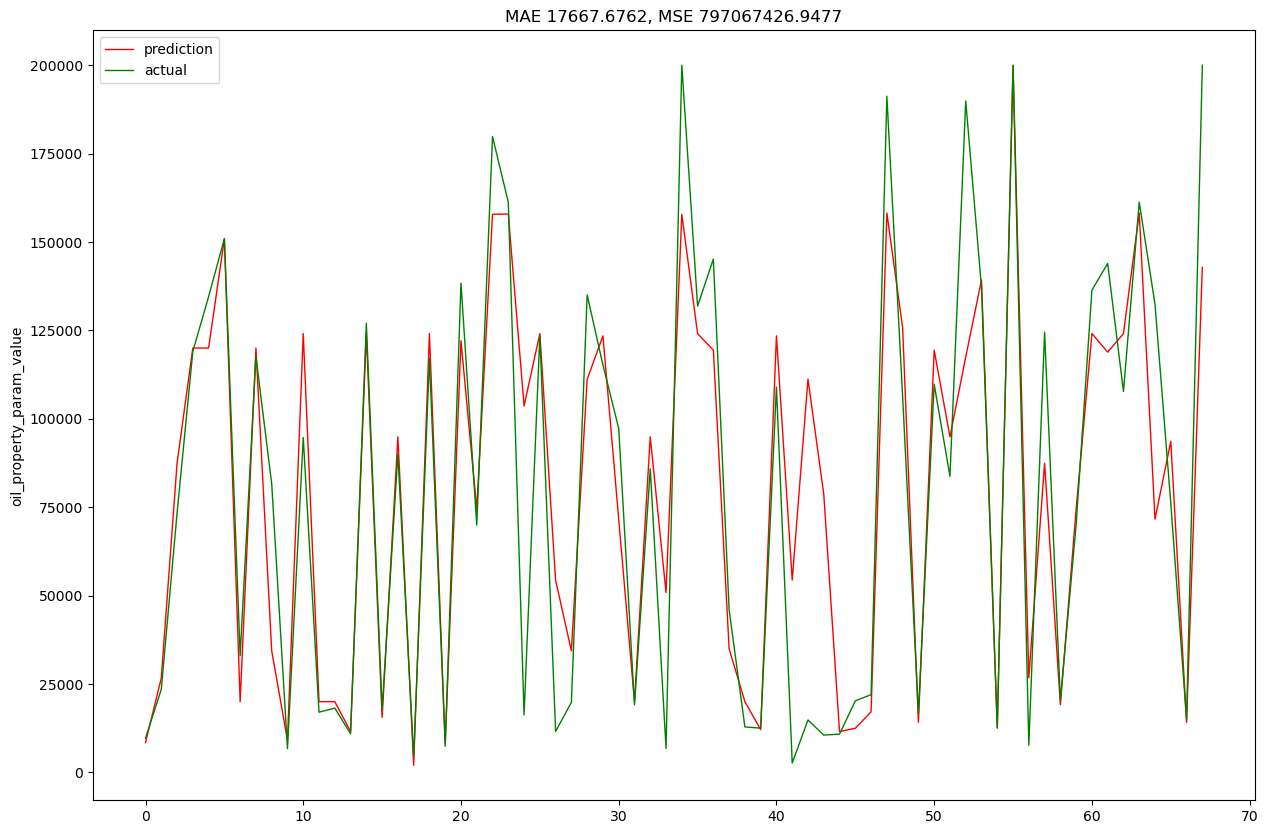

MAE score: 17667.6762
MSE score: 797067426.9477

Stack model


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


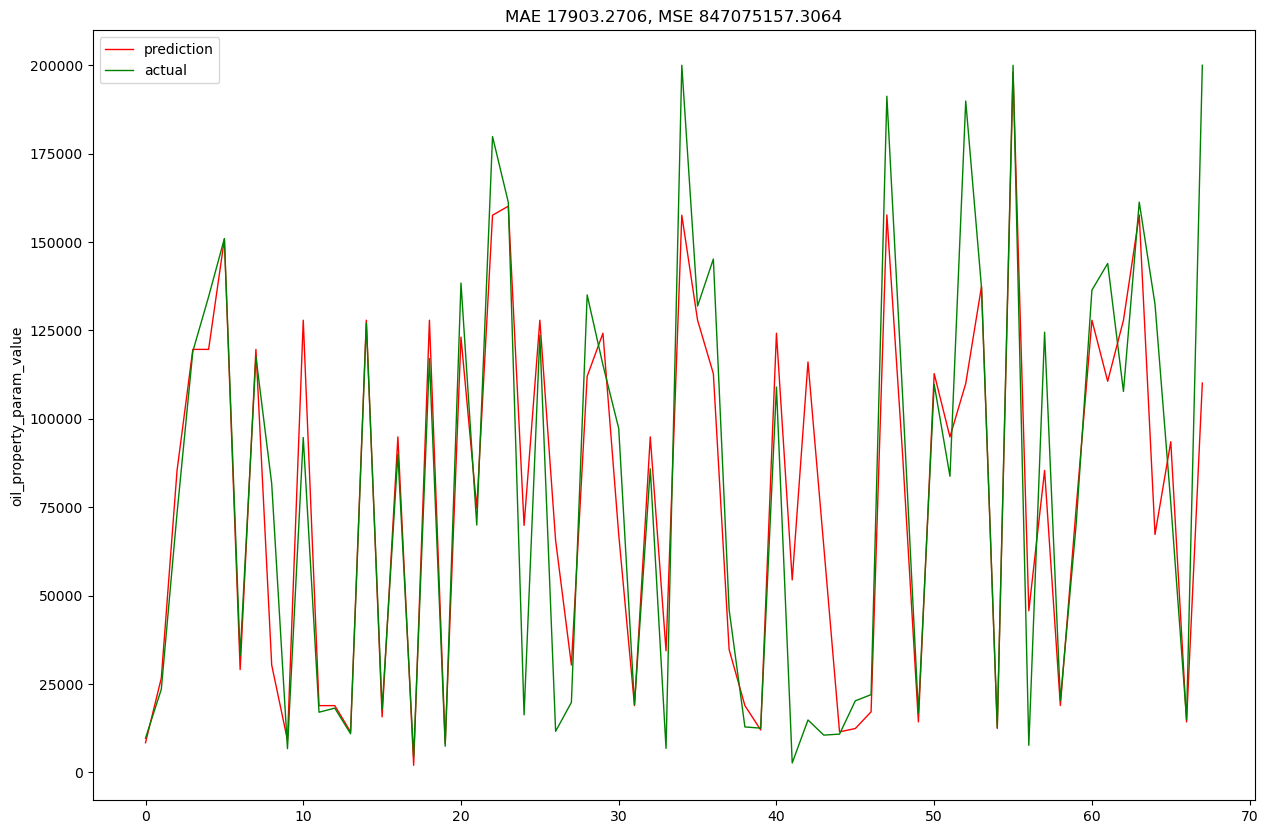

MAE score: 17903.2706
MSE score: 847075157.3064


In [10]:
config = load_config("config.yml", "embeddings", "SmallNN")
regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
regression_models.fit_and_evaluate()

In [12]:
regression_models.ridge_test()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


(RandomForestRegressor(criterion='absolute_error', n_estimators=1000, verbose=1),
 LGBMRegressor(n_estimators=2000, random_state=3),
 GradientBoostingRegressor(n_estimators=2000, random_state=45),
 array([61794.8475, 33693.285 , 36897.145 , 24450.11  , 33864.47  ,
        35053.2775, 34585.965 , 37863.2325, 45764.4625, 33182.245 ,
        35730.03  , 62837.435 , 39911.2375, 31628.18  , 40276.9675,
        31612.335 , 29994.953 , 36788.58  , 36262.4   , 36065.9575,
        36897.145 , 28991.4265, 24450.11  , 33453.9675, 37296.6225,
        24450.11  , 37863.2325, 40860.975 , 39484.8975, 42235.695 ,
        44261.175 , 69916.745 , 36026.4225, 49435.585 , 71945.7225,
        31298.715 , 32037.4675, 37093.6525, 33411.935 , 28991.4265,
        24450.11  , 36065.9575, 39357.57  , 33456.0675, 27745.01  ,
        31787.2175, 24450.11  , 33453.9675, 31898.1965, 31628.18  ,
        31375.955 , 40763.03  , 36262.4   , 32753.1575, 43868.6775,
        69916.745 , 30738.3175, 61794.8475, 29837.9225,

In [13]:
# from utils import SmallNN

# nn_model = SmallNN(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), config=config)
# nn_model.fit_and_evaluate()

In [12]:
# from sklearn.model_selection import train_test_split
# scaler_ = StandardScaler() # RobustScaler

# regressor = LstmRegressor(units=50, dropout_rate=0.005, optimizer='rmsprop', epochs=200, 
#                           batch_size=8, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

# X_train, X_test, y_train, y_test = train_test_split(
#             dataset.data_x.reshape(config['input']), dataset.data_y.reshape(config['input'][0]), test_size=0.2, random_state=42
#         )
# model, _ = regressor.fit(X_train, y_train, X_test, y_test)